In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from array import *
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import minimize

dataCompile() compiles all of the equities passed through the paramter and places them into a dataframe. It also removes any NaN values as well as sorts the prices so that it is most recent to least recent

In [3]:
ETFs = ["IVV", "VB", "VO", "VTI", "VWO", "VXUS", "BSV", "BIV", "BLV", "GLD", "SLV", "VDE", "VNQ"]
def dataCompile(etf_list):
    rawPricesdf = pd.DataFrame()

    for ticker in etf_list:
        data = yf.download(ticker)
        flippedData = data['Adj Close'].iloc[::-1]
        flippedData.name = ticker 
        rawPricesdf = pd.concat([rawPricesdf, flippedData], axis=1)
        rawPricesdf.dropna(inplace = True)

    return rawPricesdf
    
compiledData = dataCompile(ETFs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Historical Simulation Risk Model 

In [4]:
def HistoricalModel(prices):
    metricsdf = pd.DataFrame(index = ['Annualized Return','Variance of Annualized Return','Standard Deviation of Annualized Return'])

    for column in list(prices):
        #calculate daily price changes using geometric mean
        
        dailyReturndf = pd.Series([0] * 2520)
        for x in range(0, 2520):
            oldPrice = prices[column].iloc[x+1] 
            currentPrice = prices[column].iloc[x]
            tempReturn = (currentPrice - oldPrice) / oldPrice
            dailyReturndf.iloc[x] = tempReturn

        yearly_returnSeries = pd.Series([0] * 10)
        for year in range(0, 2520, 252):
             per_year_data = dailyReturndf.iloc[year: year + 252]

             sumTemp = 1
             for x in reversed(range(252)):
                 sumTemp = sumTemp * (1 + per_year_data.iloc[x])
            
             per_year_Return = sumTemp
             yearly_returnSeries.iloc[year//252] = per_year_Return 
             
        YearlyReturn_Avg = np.average(yearly_returnSeries)
        YearlyReturn_Var = yearly_returnSeries.var()
        YearlyReturn_Std = yearly_returnSeries.std()

        tempdf = pd.DataFrame(pd.DataFrame([YearlyReturn_Avg, YearlyReturn_Var, YearlyReturn_Std], index=['Annualized Return','Variance of Annualized Return','Standard Deviation of Annualized Return'], columns=[column]))

        metricsdf[column] = tempdf
    return metricsdf #average yearly return with variance/standard deviation of annual return         

HistoricalModel(compiledData)
            

,IVV,VB,VO,VTI,VWO,VXUS,BSV,BIV,BLV,GLD,SLV,VDE,VNQ
Annualized Return,1.130840,1.092820,1.100569,1.125632,1.051623,1.050165,1.013100,1.019340,1.027805,1.042407,1.017149,1.057348,1.070801
Variance of Annualized Return,0.014578,0.020809,0.015168,0.015972,0.038461,0.017250,0.000786,0.003109,0.012110,0.006583,0.038792,0.067470,0.021878
Standard Deviation of Annualized Return,0.120738,0.144253,0.123157,0.126379,0.196114,0.131340,0.028032,0.055755,0.110044,0.081134,0.196957,0.259749,0.147913


Iterative Monte Carlo Simulation

In [5]:
def normDistr(mean, std, repeat):
    #Use Box-Muller transformation to manually generate random numbers from a normal distribution based on unique mean and std.
    list = np.empty(repeat)
    for x in range (repeat):
        u1 = np.random.rand()
        u2 = np.random.rand()
        z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
        z1 = z1*std + mean

        list[x] = z1
    
    return list

#used to normalize portfolio weights for genetic algorithm solution
def normalize_portfolio_weights(weights):
    total = np.sum(weights)
    for i in range(len(weights)):
        weights[i] /= total
    
    return weights
    

In [6]:
def MonteCarloSimulation(prices, numYears, numSimulations, weights):
    HistoricalMetrics = HistoricalModel(prices)
    num_assets = len(prices.columns)
    
    indexfR = pd.Series()
    for x in range(numYears):
        indexfR[x] = 'Year ' + str(x)
    
    
    indexnS = pd.Series()
    for x in range(numSimulations):
        indexnS[x] = 'Simulation ' + str(x + 1)

    simulation_metrics_df = pd.DataFrame(index = indexnS, columns = ['Annualized Return'])
    for x in range(numSimulations):
        
        future_returnsdf = pd.DataFrame(index = indexfR)
        for k in range(num_assets):
            mean = HistoricalMetrics.iloc[0,k]
            std = HistoricalMetrics.iloc[2,k]
            randomReturns = normDistr(mean,std,numYears)
            future_returnsdf[prices.columns[k]] = randomReturns

        portfolioReturn = 0
        for y in range(len(future_returnsdf.columns)): #every asset
            log_sum = np.sum(np.log(future_returnsdf.iloc[:, y]))
            geo_mean = np.exp(log_sum / len(future_returnsdf.index)) - 1
            weighted_geo_mean = geo_mean * weights[y]
    
            portfolioReturn += weighted_geo_mean
        
        simulation_metrics_df.iloc[x] = portfolioReturn
  
    return np.mean(simulation_metrics_df), np.std(simulation_metrics_df.iloc[:,0])

Genetic Algorithm Optimization utilizing a monte carlo simulation to optimize sharpe weights by adjusting portfolio weights

In [16]:
def objective_function(Weights): 
        mean_portfolio_return, std_portfolio_return = MonteCarloSimulation(compiledData, 5, 10,Weights)
        sharpe_Ratio = ((mean_portfolio_return - .0525) / std_portfolio_return)

        return (-sharpe_Ratio) # Negative for minimization

def GeneticAlgorithmOptimization(prices):

    num_assets = len(prices.columns)

    varbound=np.array([[0,1]] * num_assets)
    algorithm_param = {'max_num_iteration': 25,
                        'population_size': 5,
                        'mutation_probability' : .2, 
                        'elit_ratio' : .05, #how much of the top weights are kept 
                        'crossover_type': 'uniform',
                        'crossover_probability': 0.9, #how much of previous is kept
                        'parents_portion' : .3, #how much diversity to keep in the population 
                        'max_iteration_without_improv': None}

    model = ga(function = objective_function, 
               dimension = num_assets, 
               variable_type='real', 
               variable_boundaries=varbound, 
               algorithm_parameters=algorithm_param)
    
    model.run()
    
    return model



 The best solution found:                                                                           
 [0.3200033  0.57223887 0.67462065 0.64615666 0.01688437 0.9543882
 0.26926905 0.31548053 0.57259103 0.6776351  0.01067269 0.02492473
 0.78931102]

 Objective function:
 -9.962087868899669


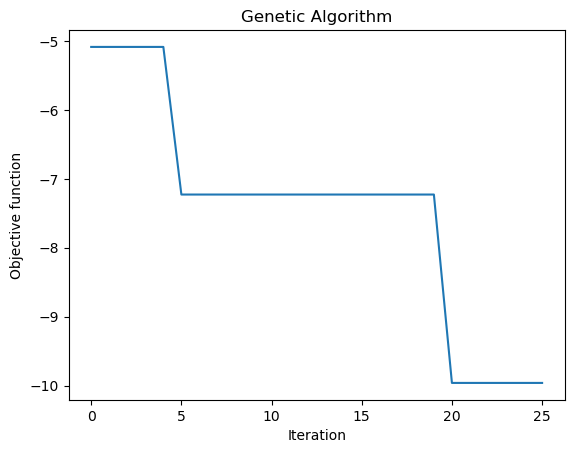

In [17]:
print(GeneticAlgorithmOptimization(compiledData))

Covariance Matrix Risk Model 

In [9]:
def CovMatrixRiskModel(prices, years):
    AllDailyReturndf = pd.DataFrame()
    trading_days = years * 252

    for column in list(prices):
        #calculate daily price changes using geometric mean

        dailyReturndf = pd.Series([0] * trading_days)
        for x in range(0, trading_days):
            oldPrice = prices[column].iloc[x+1] 
            currentPrice = prices[column].iloc[x]
            tempReturn = (currentPrice - oldPrice) / oldPrice
            dailyReturndf.iloc[x] = tempReturn
        
        AllDailyReturndf[column] = dailyReturndf
    
    num_assets = len(AllDailyReturndf.columns)
    num_days = len(AllDailyReturndf.index)

    covMatrix = pd.DataFrame(columns = prices.columns, index = prices.columns)
    
    #Calculates covariance between all assets
    for i in range(num_assets):
        for j in range(num_assets):
            i_column = AllDailyReturndf.iloc[:,i]
            j_column = AllDailyReturndf.iloc[:,j]
            average_i_return = np.mean(i_column)
            average_j_return = np.mean(j_column)

            tempCOV = 0
            for k in range(num_days):
                tempCOV += (i_column.iloc[k] - average_i_return) * (j_column.iloc[k] - average_j_return)
            
            tempCOV/(num_days - 1)

            covMatrix.iloc[i,j] = tempCOV
    
    return covMatrix #Covariance Matrix of daily return 



SLSQP optimization utilizing covariance matrix

In [10]:
#For ease of use
def ExpectedReturns(data):
    return (HistoricalModel(data).iloc[0] - 1)

#objective function to minimize using scipy
def objective(weights):
    cov_matrix = CovMatrixRiskModel(compiledData, 10)

    portfolio_return = np.dot(weights,ExpectedReturns(compiledData))
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights)))

    risk_free_rate = .0525

    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std

    return -sharpe_ratio

#constraint 1 - the weights of portfolio must equal 1
def constraint1(weights):
    return (np.sum(weights) - 1)

cons1 = {'type' : 'eq', 'fun': constraint1}

#constraint 2- the investment return must be greater than or equal to 6%
def constraint2(weights):
    expected_returns = ExpectedReturns(compiledData)

    return np.dot(weights,expected_returns) - .06

cons2 = {'type' : 'ineq', 'fun' :constraint2}

#constraints
cons = [cons1,cons2]

#initial guess
x0 = np.zeros(len(ExpectedReturns(compiledData)))
for x in range (len(ExpectedReturns(compiledData))):
    x0[x] = (1/13)

#bounds
bnds = np.empty((len(ExpectedReturns(compiledData))), dtype = 'object')
b = (0,.4)
for x in range (len(ExpectedReturns(compiledData))):
    bnds[x] = b

sol = minimize(fun = objective, x0 = x0, method = 'SLSQP', bounds = bnds, constraints = cons)


In [15]:
slsqp_solution = sol.x
print(sol)
print(slsqp_solution)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.1273137126193256
       x: [ 4.000e-01  3.327e-16 ...  0.000e+00  0.000e+00]
     nit: 9
     jac: [-1.326e-01 -3.728e-02 ...  4.350e-02 -1.824e-02]
    nfev: 126
    njev: 9
[4.00000000e-01 3.32678109e-16 3.33066907e-16 4.00000000e-01
 0.00000000e+00 1.20147309e-16 0.00000000e+00 4.67067927e-17
 4.81606987e-17 2.00000000e-01 1.08045798e-16 0.00000000e+00
 0.00000000e+00]
